C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:34:19 - cmdstanpy - INFO - Chain [1] start processing
16:34:21 - cmdstanpy - INFO - Chain [1] done processing


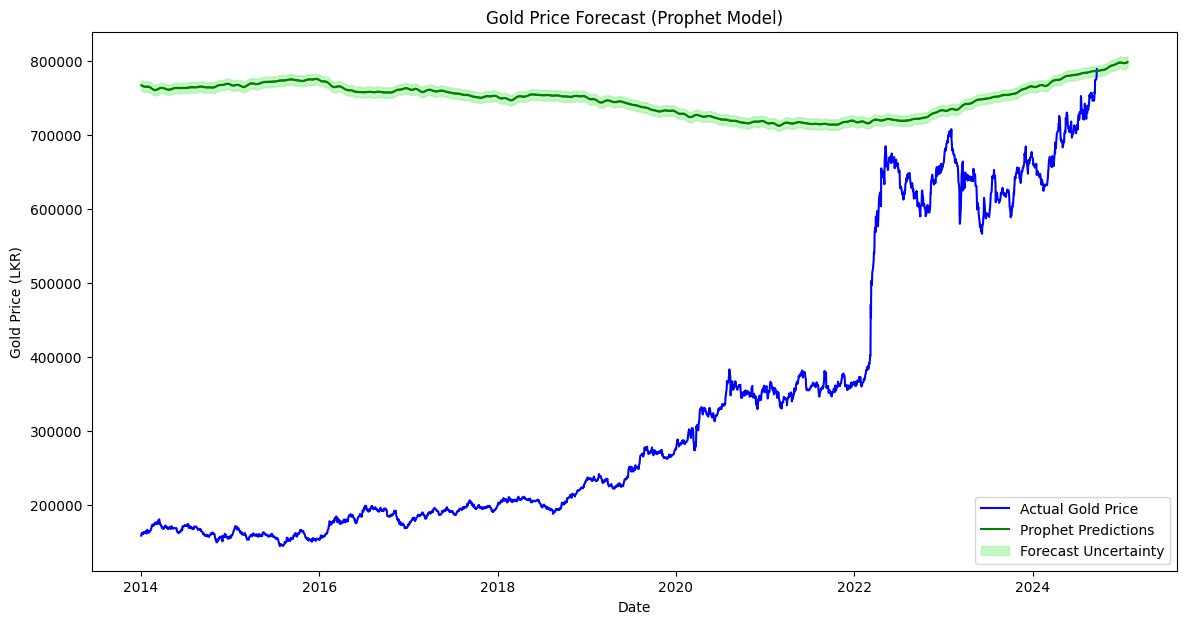

Forecasted values have been saved to 'prophet_forecast_results.csv'.


In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Initialize Prophet model with seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add external regressors to the model
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the model on the available data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions on the entire dataset
future = prophet_model.make_future_dataframe(periods=90, freq='B')  # Business day frequency
# Use the last available values of the regressors to extend into the future
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Predict future values using Prophet
forecast = prophet_model.predict(future)

# Plot the forecast
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(df['ds'], df['y'], label='Actual Gold Price', color='blue')

# Plot predicted values
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Predictions', color='green')

# Show the forecasted range
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgreen', alpha=0.5, label='Forecast Uncertainty')

plt.title('Gold Price Forecast (Prophet Model)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the forecast to a CSV file
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prophet_forecast_results.csv', index=False)

# Confirm the file has been saved
print("Forecasted values have been saved to 'prophet_forecast_results.csv'.")


In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Split the data into 80% training and 20% testing
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Initialize Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add external regressors to the model
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the model on the training data
prophet_model.fit(train[['ds', 'y'] + regressors])

# Create a DataFrame for the test period
future_test = test[['ds'] + regressors]

# Predict on the test set
forecast_test = prophet_model.predict(future_test)

# Calculate the RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse_test}')

# Forecast each regressor using Prophet
future_dates = pd.date_range(start=df['ds'].max(), periods=30, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

for regressor in regressors:
    # Create a new Prophet model for each regressor
    regressor_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    
    # Rename the regressor column to 'y' and train on the regressor data
    regressor_data = df[['ds', regressor]].rename(columns={regressor: 'y'})
    
    # Fit the regressor model
    regressor_model.fit(regressor_data)
    
    # Create future DataFrame and predict the regressor's future values
    regressor_future = regressor_model.make_future_dataframe(periods=30, freq='B')
    regressor_forecast = regressor_model.predict(regressor_future)
    
    # Add the forecasted regressor values to the future DataFrame
    future[regressor] = regressor_forecast['yhat'].iloc[-30:]

# Check if there are any NaN values in the future DataFrame
print(future.isna().sum())

# Fill any remaining NaN values in the future DataFrame if necessary
# (This step ensures that the Prophet model doesn't fail due to missing values)
future.fillna(method='ffill', inplace=True)
future.fillna(method='bfill', inplace=True)

# Use the trained Prophet model to predict the next 90 days for the target variable (gold_lkr)
forecast_future = prophet_model.predict(future)

# Plot the forecast
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(df['ds'], df['y'], label='Actual Gold Price', color='blue')

# Plot predicted values for the test set
plt.plot(test['ds'], forecast_test['yhat'], label='Prophet Predictions (Test Set)', color='red')

# Plot forecasted values for the next 90 days
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Future Forecasted Gold Price (Prophet)', color='green')

# Show the forecasted range (uncertainty intervals)
plt.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='lightgreen', alpha=0.5, label='Forecast Uncertainty')

plt.title('Gold Price Forecast (Prophet Model with Regressor Forecasting)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the forecast to a CSV file
forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prophet_forecast_with_regressors_fixed.csv', index=False)

# Confirm the file has been saved
print("Forecasted values have been saved to 'prophet_forecast_with_regressors_fixed.csv'.")


10:54:28 - cmdstanpy - INFO - Chain [1] start processing
10:54:29 - cmdstanpy - INFO - Chain [1] done processing
10:54:29 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Squared Error (RMSE) on Test Set: 44648.98841383181


10:54:30 - cmdstanpy - INFO - Chain [1] done processing
10:54:30 - cmdstanpy - INFO - Chain [1] start processing
10:54:30 - cmdstanpy - INFO - Chain [1] done processing
10:54:31 - cmdstanpy - INFO - Chain [1] start processing
10:54:31 - cmdstanpy - INFO - Chain [1] done processing
10:54:32 - cmdstanpy - INFO - Chain [1] start processing
10:54:32 - cmdstanpy - INFO - Chain [1] done processing
10:54:33 - cmdstanpy - INFO - Chain [1] start processing
10:54:34 - cmdstanpy - INFO - Chain [1] done processing
10:54:34 - cmdstanpy - INFO - Chain [1] start processing
10:54:35 - cmdstanpy - INFO - Chain [1] done processing
10:54:36 - cmdstanpy - INFO - Chain [1] start processing
10:54:36 - cmdstanpy - INFO - Chain [1] done processing


ds                     0
gold_price_usd        30
silver_price          30
s&p_500_index         30
nyse_com_index        30
usd_selling_exrate    30
gold_futures          30
effr                  30
dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_44404\1204469358.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_44404\1204469358.py:69: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='bfill', inplace=True)


ValueError: Found NaN in column 'gold_price_usd'